In [1]:
%matplotlib inline
import fitsio as ft
import numpy  as np
import healpy as hp
import matplotlib.pyplot as plt
from   desitarget import isELG_colors # local copy of desitarget.cuts
from   time import time
import logging
import warnings

In [2]:
plt.rc('font', family='serif', size=15)
plt.rc('axes.spines', right=False, top=False)
warnings.filterwarnings('ignore')
logging.basicConfig(format='%(asctime)s - %(message)s', level=logging.INFO)
logger = logging.getLogger('MonteCarlo')

In [5]:
def mag2flux(mag) :
    return 10**(-0.4*(mag-22.5))


def flux2mag(flux) :
    mag = -2.5*np.log10(flux*(flux>0)+0.001*(flux<=0)) + 22.5
    mag[(flux<=0)] = 0.
    return mag


class MonteCarlo(object):
    '''
        (c) Ashley Ross, Anand Raichoor, Julian Bautista
    
    '''
    def __init__(self, 
                 truth='desi_mcsyst_truth.dr7.34ra38.-7dec-3.fits',
                 gmag_cut=24.5,
                 south=True,
                 seed=1,
                 colorcuts_function=isELG_colors,
                 plot_truth=False):
        '''
            truth    = name of the truth catalog
            south    = True/False [default : True]
            gmag_cut = g-band mag cut [default : 24.5]
        '''
        self.colorcuts_function = colorcuts_function
        self.truth = ft.read(truth, lower=True)

        ntruth_i   = len(self.truth)
        gcut_mask  = self.truth['g'] < gmag_cut # cut based on g-mag
        self.truth = self.truth[gcut_mask]      # binary mask applied
        ntruth_f   = len(self.truth)
        
        # print
        logger.info('Truth columns : {}'.format(self.truth.dtype.names))
        logger.info('Truth size (before) : {}'.format(ntruth_i))
        logger.info('Applied (g-mag < {})    '.format(gmag_cut))
        logger.info('Truth size (after)  : {}\n\n'.format(ntruth_f))
        
        
        # g, r, z magnitudes
        self.gmag = self.truth['g']
        self.rmag = self.truth['r']
        self.zmag = self.truth['z']
        
        logger.info('gmag_min=%.2f gmag_max=%.2f gmax_length=%d'\
              %(self.gmag.min(), self.gmag.max(), self.gmag.size))

        
        # mag to flux
        self._mag2flux()
        
        # perform the selection on the truth
        self._true_select(south=south)
        
        # plot the truth
        if plot_truth:
            self._plot_truth()
        
        # generate randoms
        np.random.seed(seed=seed) # set the seed
        #seed = 1
        #rand = np.random.RandomState(seed)

        self.grand = np.random.normal(size=self.gflux.shape)
        self.rrand = np.random.normal(size=self.rflux.shape)
        self.zrand = np.random.normal(size=self.zflux.shape)
        
        #
        ## self.ELGeffcalc()
        self.photz = self.truth['hsc_mizuki_photoz_best']

        
    def __call__(self):
        sel1,mg,mr,mz = self.ELGsel(0.013, 0.02, .04) #deep
        #print(getdper(0.013,0.02,.04))
        #out1 = ~true_selection & sel1
        sel2,mg,mr,mz = self.ELGsel(0.023,0.041,.06) #slightly worse than median
        #print(getdper(0.023,0.041,.06))
        #out2 = ~true_selection & sel2
        sel3,mg,mr,mz = self.ELGsel(0.04,0.065,.085) #shallow
        #print(getdper(0.04,0.065,.085))
        #out3 = ~true_selection & sel3
        
        da = 0.03,0.055,.075
        sel4,mg,mr,mz = self.ELGsel(da[0],da[1],da[2])
        #print(getdper(da[0],da[1],da[2]))
        da = 0.018,0.0344,.051
        sel5,mg,mr,mz = self.ELGsel(da[0],da[1],da[2])
        #print(getdper(da[0],da[1],da[2]))        
        
        #
        fig, ax = plt.subplots(ncols=2, figsize=(10, 4))
        fig.subplots_adjust(wspace=0.3)
        kw = dict(range=(0.6,1.6),bins=30,histtype='step',linewidth=3)
        ax[0].hist(self.photz[sel1], **kw)
        ax[0].hist(self.photz[sel2], **kw)
        ax[0].hist(self.photz[sel3], **kw)
        ax[0].set_xlabel('photoz')
        ax[0].set_ylabel('number of targets passing selection')
        ax[0].legend(['95th percentile depth',
                    '50th percentile depth',
                    '5th percentile depth'], 
                     loc='upper right', fontsize=10)
        
        kw = dict(range=(0.6,1.6),bins=30)
        h1 = np.histogram(self.photz[sel1], **kw)
        h2 = np.histogram(self.photz[sel2], **kw)
        h3 = np.histogram(self.photz[sel3], **kw)
        h4 = np.histogram(self.photz[sel4], **kw)
        h5 = np.histogram(self.photz[sel5], **kw)
        
        xl = 0.5*(h1[1][:-1]+ h1[1][1:])
        #xl = np.zeros(len(h1[0]))
        #for i in range(0,len(xl)):
        #    xl[i] = (h1[1][i]+h1[1][i+1])/2.
        
        ax[1].plot(xl, h5[0]-h1[0])
        ax[1].plot(xl, h2[0]-h1[0])
        ax[1].plot(xl, h4[0]-h1[0])
        ax[1].plot(xl, h3[0]-h1[0])
        ax[1].axhline(1.0, color='k', ls=':')
        ax[1].set_xlabel('photoz')
        ax[1].set_ylabel(r'$\Delta N$ vs. 95th percentile')
        ax[1].legend(['75th percentile depth',
                      '50th percentile depth',
                      '25th percentile depth',
                      '5th percentile depth'],
                     loc='upper right', fontsize=10)
        plt.show()

    
    def ELGsel(self, *arrays, plot_hists=False):
        selection, mgflux, mrflux, mzflux = self._ELGsel(*arrays)
        
        out  = ~self.true_selection & selection
        zout = selection & (self.photz < 0.8)
        logger.info('gsig,rsig,zsig : {0}, {1}, {2}'.format(*arrays))
        logger.info('Out : %d Sel : %d true : %d Zout : %d'\
              %(out.sum(), selection.sum(), 
                self.true_selection.sum(), zout.sum()))
        

        if plot_hists:            
            fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(15, 8))
            ax = ax.flatten()

            kwargs = dict(range=(0,2),bins=100,histtype='step')
            ax[0].hist(self.gflux[selection], **kwargs, color='b', label='Sel', ls='-')
            ax[0].hist(self.gflux[self.true_selection], **kwargs, color='g', label='True', ls='--')   
            ax[0].hist(self.gflux[out], **kwargs, color='purple', label='Out', ls='-.')
            ax[0].hist(mgflux[zout], **kwargs, color='red', label='Zout')
            ax[0].set_xlabel('g flux')

            kwargs = dict(range=(0,2),bins=100,histtype='step')
            ax[1].hist(self.rflux[selection], color='b', label='Sel', **kwargs, ls='-')
            ax[1].hist(self.rflux[self.true_selection], color='g', label='True', **kwargs, ls='--')
            ax[1].hist(self.rflux[out], **kwargs, color='purple', label='Out', ls='-.')
            ax[1].hist(self.mrflux[zout], **kwargs, color='red', label='Zout')
            ax[1].set_xlabel('r flux')

            kwargs = dict(range=(0,3),bins=100,histtype='step')
            ax[2].hist(self.zflux[selection], color='b', label='Sel', **kwargs, ls='-')
            ax[2].hist(self.zflux[self.true_selection], color='g', label='True', **kwargs, ls='--')
            ax[2].hist(self.zflux[out], **kwargs, color='purple', label='Out', ls='-.')
            ax[2].hist(self.mzflux[zout], **kwargs, color='red', label='Zout')
            ax[2].set_xlabel('z flux')

            kwargs = dict(range=(0,1.5),bins=100,histtype='step')
            ax[3].hist(self.gflux[selection]/self.rflux[selection], color='b', label='Sel', **kwargs,ls='-')
            ax[3].hist(self.gflux[self.true_selection]/self.rflux[self.true_selection], color='g', label='True', **kwargs, ls='--')
            ax[3].hist(self.gflux[out]/self.rflux[out], **kwargs, color='purple', label='Out', ls='-.')
            ax[3].hist(self.mgflux[zout]/self.rflux[zout], **kwargs, color='red', label='Zout')
            ax[3].set_xlabel('g/r flux')


            kwargs = dict(range=(0,1.5),bins=100,histtype='step')
            ax[4].hist(self.rflux[selection]/self.zflux[selection], color='b', label='Sel', **kwargs, ls='-')
            ax[4].hist(self.rflux[self.true_selection]/self.zflux[self.true_selection], color='g', label='True', **kwargs, ls='--')
            ax[4].hist(self.rflux[out]/self.zflux[out], **kwargs, color='purple', label='Out', ls='-.')
            ax[4].hist(self.mrflux[zout]/self.zflux[zout], **kwargs, color='red', label='Zout')
            ax[4].set_xlabel('r/z flux')


            ax[5].hist(self.photz[selection], **kwargs, color='b', label='Sel', ls='-')
            ax[5].hist(self.photz[self.true_selection], **kwargs, color='g', label='True', ls='--')
            ax[5].hist(self.photz[out], **kwargs, color='purple', label='Out', ls='-.')
            ax[5].set_xlabel('photoz')

            ax[0].legend(ncol=2, frameon=False,
                         bbox_to_anchor=(0, 1.1, 2, 0.4), 
                         loc="lower left", mode="expand", borderaxespad=0)
            plt.show()
        
        return selection, mgflux, mrflux, mzflux
    
    def _ELGsel(self, gsig, rsig, zsig,
                south=True, snrc=True):
        '''
        (c) https://github.com/desihub/LSS/blob/master/Sandbox/MCeff.ipynb
        calculate the ELG selection for 
        given g,r,z flux uncertainties 
        and a given region's selection
        '''
        self.mgflux = self.gflux + self.grand*gsig
        self.mrflux = self.rflux + self.rrand*rsig
        self.mzflux = self.zflux + self.zrand*zsig

        #combined signal to noise; tractor ignores anything < 6
        combined_snr = np.sqrt(self.mgflux**2/gsig**2\
                               +self.mrflux**2/rsig**2\
                               +self.mzflux**2/zsig**2) 

        selection = self.colorcuts_function(gflux=self.mgflux, 
                                            rflux=self.mrflux, 
                                            zflux=self.mzflux, 
                                            w1flux=self.w1flux, 
                                            w2flux=self.w2flux, 
                                            south=south) 
        if snrc:
            selection &= ( combined_snr > 6 ) & ( self.mgflux > 4*gsig )
            selection &= ( self.mrflux > 3.5*rsig ) & ( self.mzflux > 2.*zsig )

        return selection, self.mgflux, self.mrflux, self.mzflux

    
    def _mag2flux(self):
        self.gflux  = mag2flux(self.gmag)
        self.rflux  = mag2flux(self.rmag)
        self.zflux  = mag2flux(self.zmag)
        self.w1flux = np.zeros_like(self.gflux)
        self.w2flux = np.zeros_like(self.gflux)    
        
    def _true_select(self, south=True):
        # selection
        self.true_selection = self.colorcuts_function(gflux=self.gflux, 
                                                      rflux=self.rflux, 
                                                      zflux=self.zflux, 
                                                      w1flux=self.w1flux, 
                                                      w2flux=self.w2flux, 
                                                      south=south)
        self.true_mean      = np.mean(self.true_selection.astype(float))
        
        # star selection
        self.star_selection = ((self.gmag-self.rmag)>(1.5*(self.rmag-self.zmag)+0.0))\
                              &((self.gmag-self.rmag)<(1.5*(self.rmag-self.zmag)+0.4))\
                              &((self.gmag-self.rmag)>(-1.5*(self.rmag-self.zmag)+0.3))\
                              &((self.gmag-self.rmag)<(-1.5*(self.rmag-self.zmag)+2.0))
        
        
    def _plot_truth(self):
        fig, ax = plt.subplots(ncols=3, figsize=(12, 4))
        fig.subplots_adjust(wspace=0.3)
        fig.suptitle('Distribution of the Truth')
        ax = ax.flatten()
        
        # r-z vs g-r
        rz = self.rmag-self.zmag
        gr = self.gmag-self.rmag
        ax[0].scatter(rz, gr, marker=".", alpha=0.2, color="gray")        
        
        ax[0].scatter(rz[self.true_selection],
                   gr[self.true_selection],
                   marker=".", color="green")
        
        ax[0].scatter(rz[self.star_selection],
                   gr[self.star_selection],
                   marker=".", color="red")        
        ax[0].set_xlabel("r-z")
        ax[0].set_ylabel("g-r")
        ax[0].text(0.8, 0.9, 'True', color='green', transform=ax[0].transAxes)
        ax[0].text(0.8, 0.8, 'Star', color='red', transform=ax[0].transAxes)        
        
        # g vs r
        ax[1].plot(self.gmag, self.rmag,'k,')
        ax[1].plot([self.gmag.min(), self.gmag.max()], # y=x line
                  [self.gmag.min(), self.gmag.max()], 'r--')
        ax[1].set_xlabel('g-mag')
        ax[1].set_ylabel('r-mag')
        
        # histogram of the g-mag
        #h = np.histogram(gmag, range=(14,25))
        kwargs = dict(range=(14,25), bins=40, density=False)
        h,_,_= ax[2].hist(self.gmag, color='grey', **kwargs)
        ax[2].hist(self.gmag[self.true_selection], color="green", **kwargs)
        ax[2].set_xlabel("g-mag")
        logger.info('hist of g-mag : {}'.format(h))
        plt.show()

2019-10-03 08:18:22,997 - Truth columns : ('brickname', 'objid', 'type', 'ra', 'dec', 'g', 'r', 'z', 'w1', 'w2', 'galdepth_g', 'galdepth_r', 'galdepth_z', 'hsc_object_id', 'hsc_ra', 'hsc_dec', 'hsc_mizuki_photoz_best')
2019-10-03 08:18:22,999 - Truth size (before) : 549181
2019-10-03 08:18:23,000 - Applied (g-mag < 24.5)    
2019-10-03 08:18:23,000 - Truth size (after)  : 156861


2019-10-03 08:18:23,005 - gmag_min=13.81 gmag_max=24.50 gmax_length=156861
2019-10-03 08:18:23,099 - gsig,rsig,zsig : 0.04, 0.06, 0.1
2019-10-03 08:18:23,101 - Out : 2365 Sel : 8674 true : 8156 Zout : 1553


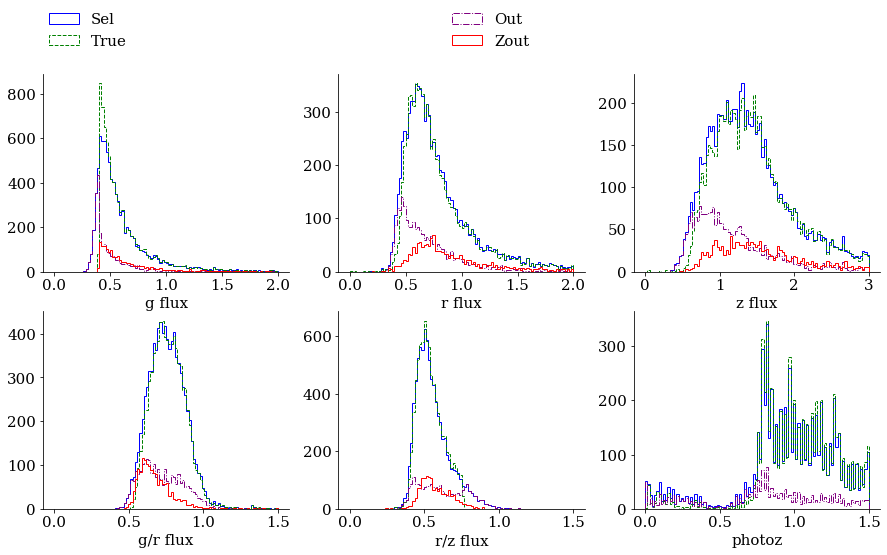

2019-10-03 08:18:24,191 - gsig,rsig,zsig : 0.013, 0.02, 0.04
2019-10-03 08:18:24,193 - Out : 703 Sel : 8159 true : 8156 Zout : 1064
2019-10-03 08:18:24,205 - gsig,rsig,zsig : 0.023, 0.041, 0.06
2019-10-03 08:18:24,208 - Out : 1373 Sel : 8331 true : 8156 Zout : 1193
2019-10-03 08:18:24,222 - gsig,rsig,zsig : 0.04, 0.065, 0.085
2019-10-03 08:18:24,224 - Out : 2366 Sel : 8677 true : 8156 Zout : 1574
2019-10-03 08:18:24,241 - gsig,rsig,zsig : 0.03, 0.055, 0.075
2019-10-03 08:18:24,244 - Out : 1816 Sel : 8442 true : 8156 Zout : 1356
2019-10-03 08:18:24,261 - gsig,rsig,zsig : 0.018, 0.0344, 0.051
2019-10-03 08:18:24,264 - Out : 1064 Sel : 8240 true : 8156 Zout : 1130


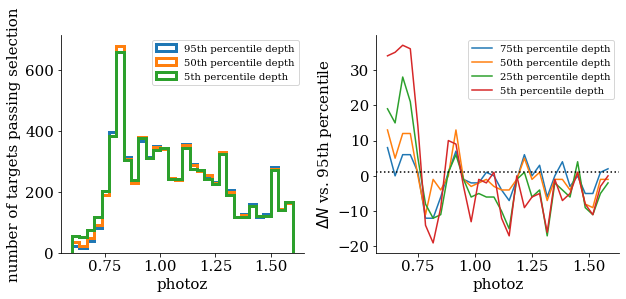

1.913 [s]


In [6]:
t0 = time()        
MC = MonteCarlo()                          # This will apply a g-mag cut, perform true selection
MC.ELGsel(0.04, 0.06, .1, plot_hists=True) # perturb the fluxes, and re-evaluate the selection
MC()                                       # perturn the fluxes multiple times, ...
t1 = time()
print('%.3f [s]'%(t1 - t0))